# Horse2Zebra Dataset

In [2]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import warnings
warnings.filterwarnings("ignore")

local_zip = 'horse_2_zebra.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/Projects/DL Lab/Week 4/Dataset/horse2zebra')
zip_ref.close()

In [4]:
import tensorflow as tf

img = tf.io.read_file("Dataset/horse2zebra/trainA/n02381460_2.jpg")
img = tf.image.decode_image(img)

print("Shape:", img.shape)

Shape: (256, 256, 3)


In [5]:
batch_size = 32
img_height = 256
img_width = 256

In [15]:
# Training dataset
train_dataset = image_dataset_from_directory(
    "Dataset/horse2zebra/Train",       # root directory
    labels="inferred",           # labels = subfolder names (trainA, trainB)
    label_mode="int",    # one-hot encoded labels
    class_names=["Horse", "Zebra"],  # order of class labels
    batch_size=32,
    image_size=(256, 256),       # resize all images
    shuffle=True,
    subset="training",
    validation_split=0.2,        # optional: split train into train/val
    seed=42
)

# Validation dataset
validation_dataset = image_dataset_from_directory(
    "Dataset/horse2zebra/Train",
    labels="inferred",
    label_mode="int",
    class_names=["Horse", "Zebra"],
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    subset="validation",
    validation_split=0.2,
    seed=42
)

Found 2401 files belonging to 2 classes.
Using 1921 files for training.
Found 2401 files belonging to 2 classes.
Using 480 files for validation.


In [16]:
# Load testing dataset
test_dataset = image_dataset_from_directory(
    "Dataset/horse2zebra/Test",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int',
    shuffle=False
)

Found 260 files belonging to 2 classes.


In [17]:
# Normalize pixel values
train_dataset = train_dataset.map(lambda x, y: (x/255, y))
validation_dataset = validation_dataset.map(lambda x, y: (x/255, y))
test_dataset = test_dataset.map(lambda x, y: (x/255, y))

In [18]:
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras import Sequential

# Create an augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

# Apply augmentation to training dataset only
augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

### LeNet

In [19]:
from tensorflow.keras import layers, models

def create_lenet():
    model = models.Sequential([
        # First convolutional layer
        layers.Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(img_height, img_width, 3)),
        layers.AveragePooling2D(pool_size=(2, 2)),
        
        # Second convolutional layer
        layers.Conv2D(16, kernel_size=(5, 5), activation='tanh'),
        layers.AveragePooling2D(pool_size=(2, 2)),
        
        # Flatten layer
        layers.Flatten(),
        
        # Fully connected layers
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        layers.Dense(2, activation='softmax')  # 2 classes: cats and dogs
    ])
    
    return model

In [20]:
model = create_lenet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 6)       456       
                                                                 
 average_pooling2d (AverageP  (None, 126, 126, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 16)      2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 61, 61, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 59536)             0         
                                                                 
 dense (Dense)               (None, 120)              

In [22]:
history = model.fit(
    augmented_train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    batch_size=batch_size,
)

Epoch 1/30
61/61 [==============================] - 12s 108ms/step - loss: 0.7711 - accuracy: 0.5539 - val_loss: 0.6648 - val_accuracy: 0.5792
Epoch 2/30
61/61 [==============================] - 5s 84ms/step - loss: 0.6566 - accuracy: 0.6143 - val_loss: 0.6204 - val_accuracy: 0.7063
Epoch 3/30
61/61 [==============================] - 5s 82ms/step - loss: 0.6265 - accuracy: 0.6830 - val_loss: 0.6204 - val_accuracy: 0.6771
Epoch 4/30
61/61 [==============================] - 5s 82ms/step - loss: 0.5947 - accuracy: 0.7022 - val_loss: 0.5756 - val_accuracy: 0.7229
Epoch 5/30
61/61 [==============================] - 5s 84ms/step - loss: 0.5801 - accuracy: 0.7158 - val_loss: 0.5629 - val_accuracy: 0.7229
Epoch 6/30
61/61 [==============================] - 5s 84ms/step - loss: 0.5701 - accuracy: 0.7231 - val_loss: 0.5980 - val_accuracy: 0.7146
Epoch 7/30
61/61 [==============================] - 5s 81ms/step - loss: 0.5443 - accuracy: 0.7460 - val_loss: 0.5594 - val_accuracy: 0.7458
Epoch 8/30


In [23]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(test_dataset, batch_size=batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

9/9 [==============================] - 1s 41ms/step - loss: 0.4531 - accuracy: 0.8000
Test Loss: 0.45305097103118896
Test Accuracy: 0.800000011920929


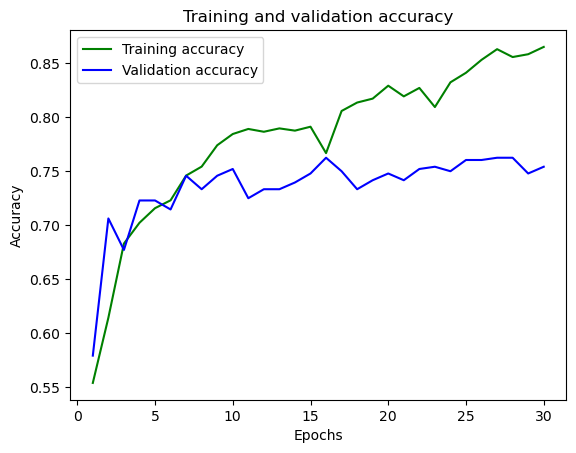

In [24]:
import matplotlib.pyplot as plt

#Plotting losses
training_loss = history.history['accuracy']
validation_loss = history.history['val_accuracy']
epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'g', label='Training accuracy')
plt.plot(epoch_range, validation_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

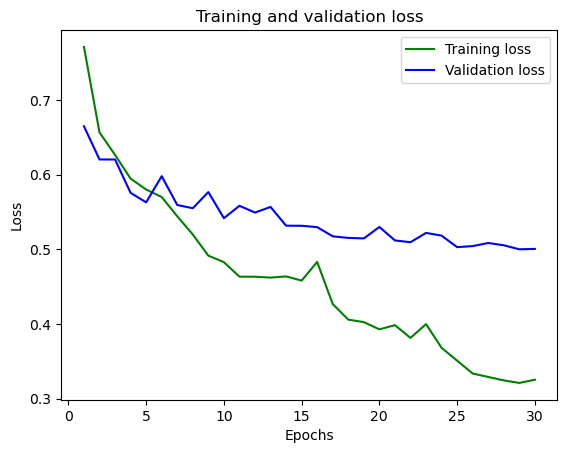

In [25]:
#Plotting losses
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'g', label='Training loss')
plt.plot(epoch_range, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### AlexNet

In [26]:
def create_alexnet():
    model = models.Sequential([
        # First Convolutional Layer
        layers.Conv2D(96, kernel_size=(11,11), strides=4, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),
        
        # Second Convolutional Layer
        layers.Conv2D(256, kernel_size=(5,5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),
        
        # Third Convolutional Layer
        layers.Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        
        # Fourth Convolutional Layer
        layers.Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        
        # Fifth Convolutional Layer|
        layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),
        
        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # 2 classes for cats and dogs
    ])
    
    return model

In [27]:
model = create_alexnet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 96)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 31, 31, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 256)      1024      
 hNormalization)                                                 
                                                      

In [30]:
history = model.fit(
    augmented_train_dataset,   
    validation_data=validation_dataset,
    epochs=30,
    batch_size=batch_size,
)

Epoch 1/30
61/61 [==============================] - 8s 116ms/step - loss: 0.4560 - accuracy: 0.8631 - val_loss: 1.0265 - val_accuracy: 0.8146
Epoch 2/30
61/61 [==============================] - 7s 111ms/step - loss: 0.3523 - accuracy: 0.8844 - val_loss: 0.3156 - val_accuracy: 0.8938
Epoch 3/30
61/61 [==============================] - 7s 110ms/step - loss: 0.3030 - accuracy: 0.9006 - val_loss: 0.3244 - val_accuracy: 0.8896
Epoch 4/30
61/61 [==============================] - 7s 109ms/step - loss: 0.2282 - accuracy: 0.9099 - val_loss: 0.1724 - val_accuracy: 0.9229
Epoch 5/30
61/61 [==============================] - 7s 111ms/step - loss: 0.2681 - accuracy: 0.9110 - val_loss: 0.2426 - val_accuracy: 0.9125
Epoch 6/30
61/61 [==============================] - 7s 109ms/step - loss: 0.2177 - accuracy: 0.9136 - val_loss: 0.2969 - val_accuracy: 0.8771
Epoch 7/30
61/61 [==============================] - 7s 107ms/step - loss: 0.1768 - accuracy: 0.9282 - val_loss: 0.1593 - val_accuracy: 0.9292
Epoch 

In [31]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(test_dataset, batch_size=batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

9/9 [==============================] - 0s 19ms/step - loss: 0.1313 - accuracy: 0.9346
Test Loss: 0.13131268322467804
Test Accuracy: 0.9346153736114502


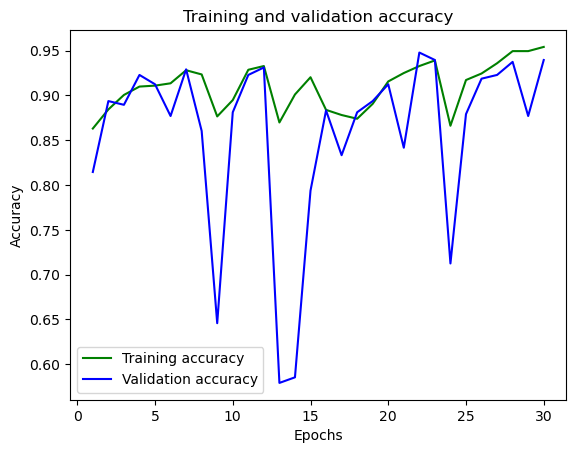

In [32]:
#Plotting losses
training_loss = history.history['accuracy']
validation_loss = history.history['val_accuracy']
epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'g', label='Training accuracy')
plt.plot(epoch_range, validation_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

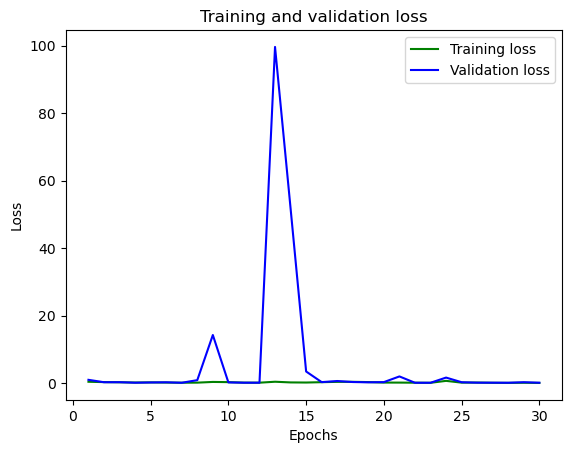

In [33]:
#Plotting losses
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'g', label='Training loss')
plt.plot(epoch_range, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The model seems quite unstable, even though it performs well

### VGG-16

In [37]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape=(256,256,3), weights='imagenet', include_top=False)
base_model.trainable = False #freeze the layers
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [38]:
import tensorflow as tf
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 2)                 65538     
                                                                 
Total params: 14,780,226
Trainable params: 65,538
Non-trainable params: 14,714,688
_________________________________________________________________


In [39]:
history = model.fit(
    augmented_train_dataset,   
    validation_data=validation_dataset,
    epochs=10,
    batch_size=batch_size,
)

Epoch 1/10
61/61 [==============================] - 18s 216ms/step - loss: 0.3707 - acc: 0.8490 - val_loss: 0.1797 - val_acc: 0.9396
Epoch 2/10
61/61 [==============================] - 12s 198ms/step - loss: 0.1919 - acc: 0.9344 - val_loss: 0.1431 - val_acc: 0.9646
Epoch 3/10
61/61 [==============================] - 12s 200ms/step - loss: 0.1565 - acc: 0.9485 - val_loss: 0.1184 - val_acc: 0.9667
Epoch 4/10
61/61 [==============================] - 12s 198ms/step - loss: 0.1370 - acc: 0.9537 - val_loss: 0.1090 - val_acc: 0.9771
Epoch 5/10
61/61 [==============================] - 12s 201ms/step - loss: 0.1165 - acc: 0.9693 - val_loss: 0.1018 - val_acc: 0.9792
Epoch 6/10
61/61 [==============================] - 12s 203ms/step - loss: 0.1109 - acc: 0.9646 - val_loss: 0.0990 - val_acc: 0.9792
Epoch 7/10
61/61 [==============================] - 12s 202ms/step - loss: 0.1024 - acc: 0.9708 - val_loss: 0.0970 - val_acc: 0.9729
Epoch 8/10
61/61 [==============================] - 13s 203ms/step - 

9/9 [==============================] - 2s 228ms/step - loss: 0.1152 - acc: 0.9654
Test Loss: 0.11519119143486023
Test Accuracy: 0.9653846025466919


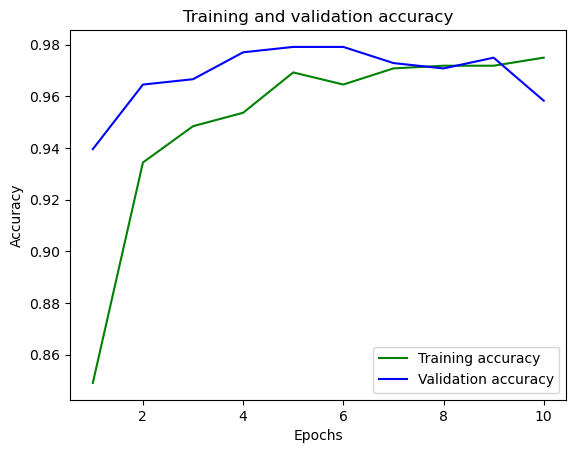

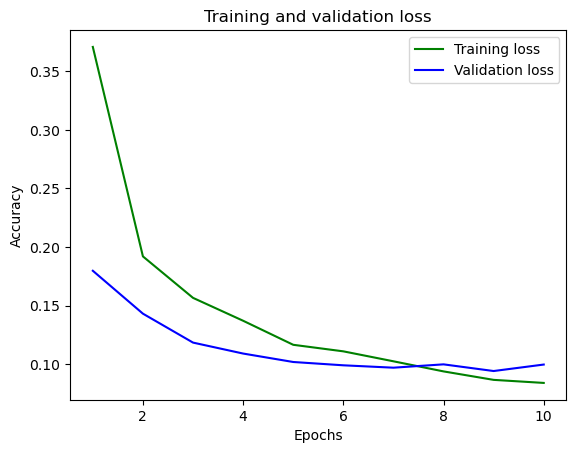

In [40]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(test_dataset, batch_size=batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

#Plotting losses
training_loss = history.history['acc']
validation_loss = history.history['val_acc']
epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'g', label='Training accuracy')
plt.plot(epoch_range, validation_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plotting losses
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'g', label='Training loss')
plt.plot(epoch_range, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### GoogleNet (InceptionNet v3)

In [43]:
from keras.applications import inception_v3

base_model = inception_v3.InceptionV3(input_shape=(256,256,3), weights='imagenet', include_top=False)
base_model.trainable = False #freeze the layers
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_101 (Conv2D)            (None, 127, 127, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_99 (BatchN  (None, 127, 127, 32  96         ['conv2d_101[0][0]']             
 ormalization)                  )                                                      

In [44]:
model = Sequential([
    base_model, 
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])
model.summary()

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 73728)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               9437312   
                                                                 
 dense_11 (Dense)            (None, 2)                 258       
                                                                 
Total params: 31,240,354
Trainable params: 9,437,570
Non-trainable params: 21,802,784
_________________________________________________________________


In [46]:
history = model.fit(
    augmented_train_dataset,   
    validation_data=validation_dataset,
    epochs=10,
    batch_size=batch_size,
)

Epoch 1/10
61/61 [==============================] - 9s 143ms/step - loss: 0.0215 - accuracy: 0.9922 - val_loss: 0.0335 - val_accuracy: 0.9875
Epoch 2/10
61/61 [==============================] - 9s 137ms/step - loss: 0.0107 - accuracy: 0.9964 - val_loss: 0.0329 - val_accuracy: 0.9896
Epoch 3/10
61/61 [==============================] - 8s 135ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.0373 - val_accuracy: 0.9896
Epoch 4/10
61/61 [==============================] - 8s 136ms/step - loss: 0.0069 - accuracy: 0.9969 - val_loss: 0.0360 - val_accuracy: 0.9896
Epoch 5/10
61/61 [==============================] - 8s 136ms/step - loss: 0.0059 - accuracy: 0.9984 - val_loss: 0.0332 - val_accuracy: 0.9896
Epoch 6/10
61/61 [==============================] - 8s 137ms/step - loss: 0.0119 - accuracy: 0.9964 - val_loss: 0.0380 - val_accuracy: 0.9896
Epoch 7/10
61/61 [==============================] - 8s 137ms/step - loss: 0.0061 - accuracy: 0.9974 - val_loss: 0.0261 - val_accuracy: 0.9917
Epoch 

9/9 [==============================] - 1s 84ms/step - loss: 0.0509 - accuracy: 0.9885
Test Loss: 0.050920747220516205
Test Accuracy: 0.9884615540504456


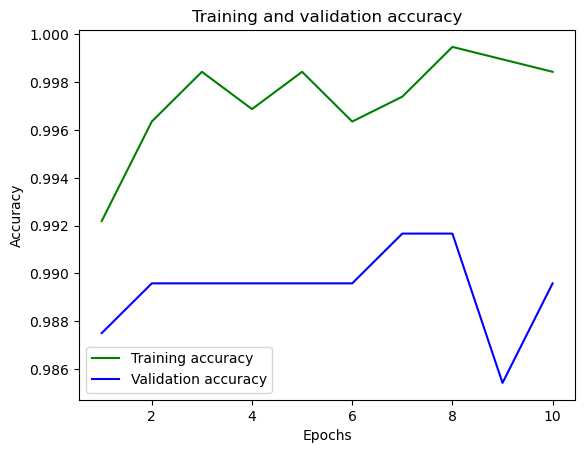

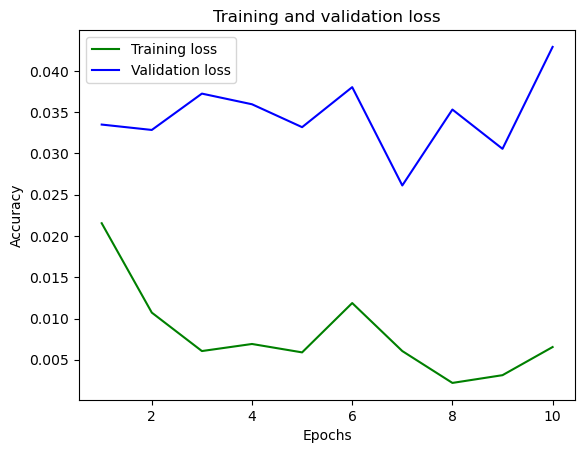

In [47]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(test_dataset, batch_size=batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

#Plotting losses
training_loss = history.history['accuracy']
validation_loss = history.history['val_accuracy']
epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'g', label='Training accuracy')
plt.plot(epoch_range, validation_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plotting losses
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'g', label='Training loss')
plt.plot(epoch_range, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### ResNet50

In [48]:
from keras.applications import ResNet50
from keras import layers, Sequential
base_model = ResNet50(input_shape=(256,256,3), weights='imagenet', include_top=False)
base_model.trainable = False #freeze the layers     
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [49]:
model = Sequential([
    base_model, 
    layers.GlobalAveragePooling2D(),    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')   
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy'])

In [50]:
history = model.fit(
    augmented_train_dataset,   
    validation_data=validation_dataset,
    epochs=30,
    batch_size=batch_size,
)

Epoch 1/30
61/61 [==============================] - 12s 158ms/step - loss: 0.6955 - accuracy: 0.5841 - val_loss: 0.5641 - val_accuracy: 0.7021
Epoch 2/30
61/61 [==============================] - 9s 145ms/step - loss: 0.6137 - accuracy: 0.6429 - val_loss: 0.5121 - val_accuracy: 0.7396
Epoch 3/30
61/61 [==============================] - 9s 148ms/step - loss: 0.5642 - accuracy: 0.6814 - val_loss: 0.6503 - val_accuracy: 0.5833
Epoch 4/30
61/61 [==============================] - 10s 155ms/step - loss: 0.5726 - accuracy: 0.6851 - val_loss: 0.4694 - val_accuracy: 0.7958
Epoch 5/30
61/61 [==============================] - 9s 144ms/step - loss: 0.5559 - accuracy: 0.7012 - val_loss: 0.4649 - val_accuracy: 0.7937
Epoch 6/30
61/61 [==============================] - 9s 143ms/step - loss: 0.5427 - accuracy: 0.7137 - val_loss: 0.4221 - val_accuracy: 0.8188
Epoch 7/30
61/61 [==============================] - 9s 143ms/step - loss: 0.5309 - accuracy: 0.7324 - val_loss: 0.4398 - val_accuracy: 0.8021
Epoc

9/9 [==============================] - 1s 89ms/step - loss: 0.3783 - accuracy: 0.8538
Test Loss: 0.37832653522491455
Test Accuracy: 0.8538461327552795


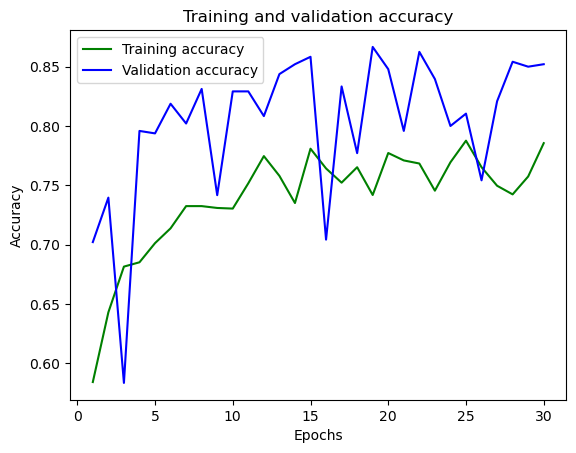

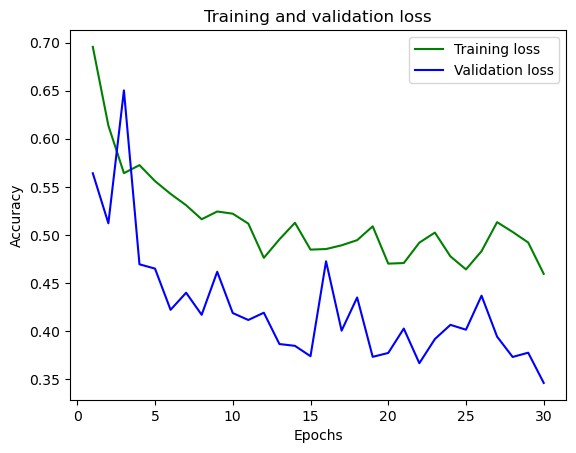

In [51]:
import matplotlib.pyplot as plt

# Evaluate the model on the testing data
loss, accuracy = model.evaluate(test_dataset, batch_size=batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

#Plotting losses
training_loss = history.history['accuracy']
validation_loss = history.history['val_accuracy']
epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'g', label='Training accuracy')
plt.plot(epoch_range, validation_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plotting losses
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'g', label='Training loss')
plt.plot(epoch_range, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### EfficientNetB0

In [55]:
from keras.applications import EfficientNetB0
from keras import layers, Sequential
from matplotlib import pyplot as plt
base_model = EfficientNetB0(input_shape=(256,256,3), weights='imagenet', include_top=False)
base_model.trainable = False #freeze the layers     
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_7[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [56]:
model = Sequential([
    base_model, 
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               327936    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                16448     
                                                      

In [57]:
history = model.fit(
    augmented_train_dataset,   
    validation_data=validation_dataset,
    epochs=30,
    batch_size=batch_size,
)

Epoch 1/30
61/61 [==============================] - 13s 138ms/step - loss: 0.7058 - accuracy: 0.5081 - val_loss: 0.6898 - val_accuracy: 0.5792
Epoch 2/30
61/61 [==============================] - 7s 119ms/step - loss: 0.6998 - accuracy: 0.5461 - val_loss: 0.6777 - val_accuracy: 0.5792
Epoch 3/30
61/61 [==============================] - 7s 119ms/step - loss: 0.6924 - accuracy: 0.5403 - val_loss: 0.6695 - val_accuracy: 0.5792
Epoch 4/30
61/61 [==============================] - 8s 125ms/step - loss: 0.6890 - accuracy: 0.5357 - val_loss: 0.6696 - val_accuracy: 0.5792
Epoch 5/30
61/61 [==============================] - 7s 120ms/step - loss: 0.6924 - accuracy: 0.5455 - val_loss: 0.6667 - val_accuracy: 0.5792
Epoch 6/30
61/61 [==============================] - 7s 119ms/step - loss: 0.6893 - accuracy: 0.5497 - val_loss: 0.6722 - val_accuracy: 0.5792
Epoch 7/30
61/61 [==============================] - 7s 119ms/step - loss: 0.6875 - accuracy: 0.5476 - val_loss: 0.6718 - val_accuracy: 0.5792
Epoch

9/9 [==============================] - 1s 55ms/step - loss: 0.6401 - accuracy: 0.5385
Test Loss: 0.6401107311248779
Test Accuracy: 0.5384615659713745


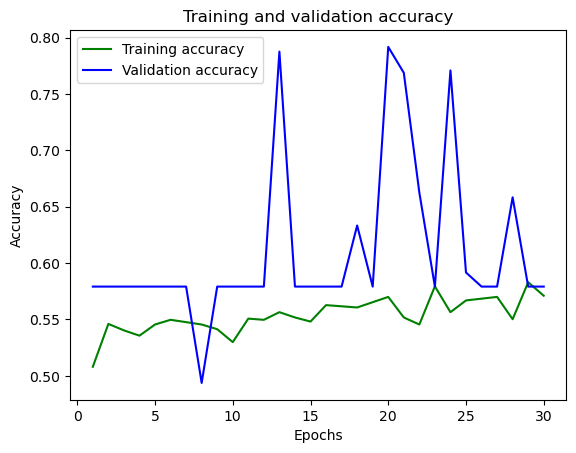

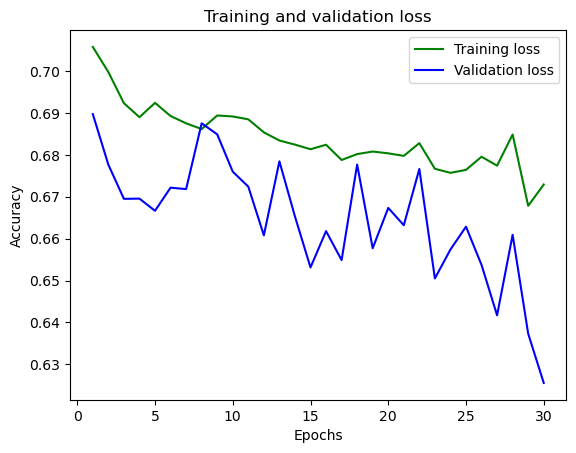

In [58]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(test_dataset, batch_size=batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

#Plotting losses
training_loss = history.history['accuracy']
validation_loss = history.history['val_accuracy']
epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'g', label='Training accuracy')
plt.plot(epoch_range, validation_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plotting losses
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'g', label='Training loss')
plt.plot(epoch_range, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

EfficientNetB0 might run well with well with extended training, and increased number of layers

### MobileNetv2

In [60]:
from keras.applications import MobileNetV2
base_model = MobileNetV2(input_shape=(256,256,3), weights='imagenet', include_top=False)
base_model.trainable = False #freeze the layers     
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [61]:
model = Sequential([
    base_model, 
    layers.Flatten(),    
    # layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])

In [62]:
history = model.fit(
    augmented_train_dataset,   
    validation_data=validation_dataset,
    epochs=30,
    batch_size=batch_size,  
)

Epoch 1/30
61/61 [==============================] - 8s 103ms/step - loss: 0.1140 - accuracy: 0.9573 - val_loss: 0.0511 - val_accuracy: 0.9875
Epoch 2/30
61/61 [==============================] - 6s 92ms/step - loss: 0.0317 - accuracy: 0.9917 - val_loss: 0.0492 - val_accuracy: 0.9875
Epoch 3/30
61/61 [==============================] - 6s 94ms/step - loss: 0.0220 - accuracy: 0.9932 - val_loss: 0.0515 - val_accuracy: 0.9917
Epoch 4/30
61/61 [==============================] - 6s 92ms/step - loss: 0.0202 - accuracy: 0.9927 - val_loss: 0.0629 - val_accuracy: 0.9917
Epoch 5/30
61/61 [==============================] - 6s 93ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 0.0789 - val_accuracy: 0.9854
Epoch 6/30
61/61 [==============================] - 6s 93ms/step - loss: 0.0203 - accuracy: 0.9958 - val_loss: 0.0798 - val_accuracy: 0.9875
Epoch 7/30
61/61 [==============================] - 6s 92ms/step - loss: 0.0058 - accuracy: 0.9974 - val_loss: 0.0691 - val_accuracy: 0.9917
Epoch 8/30
6

9/9 [==============================] - 1s 49ms/step - loss: 0.0938 - accuracy: 0.9846
Test Loss: 0.09378842264413834
Test Accuracy: 0.9846153855323792


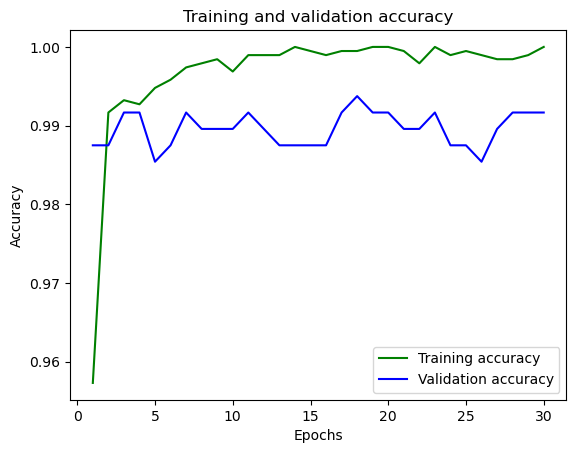

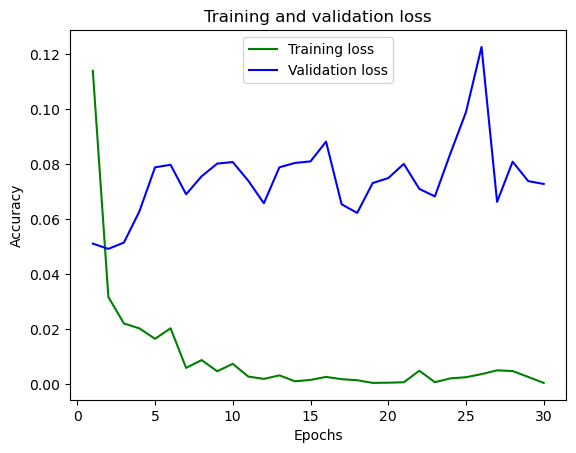

In [63]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(test_dataset, batch_size=batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

#Plotting losses
training_loss = history.history['accuracy']
validation_loss = history.history['val_accuracy']
epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'g', label='Training accuracy')
plt.plot(epoch_range, validation_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plotting losses
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'g', label='Training loss')
plt.plot(epoch_range, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()